# **Judging a book by it's cover**
**By training CNN from scratch**


**Navigating throught this notebook:**
1.   Importing modules
2.   Defining functions 
3.   Image Tranformation
4.   Convotional neural network from scratch








**Importing necessary modules**

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os
import torch.optim as optim
# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [3]:
%cd My Drive

/gdrive/My Drive


**Defining the functions**

In [0]:
# Function to display images
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [0]:
# To show how augmentation works, we need to write a function that will plot a tensor as an image.
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

**Load dataset into notebook**


*   I have web scrapped 57000 cover images and 20 different categories of Books but due to time constraint [runtime] I have selected only 5 categories which had more number of images


In [0]:
# Define data directory and subdirectories
data_dir= 'BookData/' 
traindir = data_dir + 'train/'
validdir = data_dir + 'val/'
testdir = data_dir + 'test/' 
# Change to fit hardware
batch_size = 32

In [11]:
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [12]:
# Display number of images per dataset i.e train, test and validation
# Empty lists
categories = []
n_train = []
n_valid = []
n_test = []
# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))
  # Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')
cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()

,category,n_train,n_valid,n_test
3,Parenting & Relationships,1420,250,250
4,Test Preparation,1381,305,300
2,Romance,1373,300,300
0,"Mystery, Thriller & Suspense",1360,310,310
1,Biographies & Memoirs,1359,320,320


In [13]:
# Number of images in train dataset
cpt = sum([len(files) for r, d, files in os.walk("BookData/train")])
print(cpt)

6893


**Image transformation**


*   I have calculated the mean and standard deviations in data exploration step but, here, I have used image net standards to normalize the image because I found that image_net standard values work best for my model.
*   When we use the images in the pre-trained network, we'll have to reshape them to 224 x 224. This is the size of Imagenet images and is therefore what the model expects. The images that are larger than this will be truncated while the smaller images will be interpolated.



In [0]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Scale((32,32))                
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Scale((32,32))
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Scale((32,32))
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


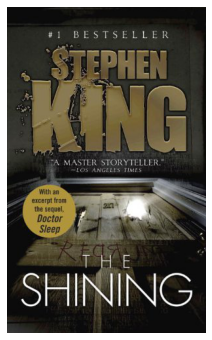

In [15]:
# Open image from train dataset
ex_img = Image.open('BookData/train/Mystery, Thriller & Suspense/0307743659.jpg')
imshow(ex_img)

<Figure size 432x432 with 0 Axes>

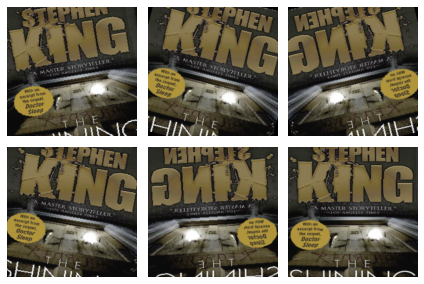

In [16]:
# Apply image transformation on traing dataset and display how image augmentation is done
t = image_transforms['train']
plt.figure(figsize=(6, 6))

for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

**Data Iterator**
To avoid loading all of the data into memory at once, we use training DataLoaders. At training time, the DataLoader will load the images from disk, apply the transformations, and yield a batch. 

In [24]:
transform = transforms.Compose(
    [ transforms.Scale((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [0]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [88]:
# Number of different classes in training dataset
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 5 different classes.


5

In [114]:
classes=cat_df['category']
classes

3       Parenting & Relationships
4                Test Preparation
2                         Romance
0    Mystery, Thriller & Suspense
1           Biographies & Memoirs
Name: category, dtype: object

In [89]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53* 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.size())
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [96]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainiter, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 2.334
[1,    40] loss: 2.336
[1,    60] loss: 2.334
[1,    80] loss: 2.330
[1,   100] loss: 2.332
[1,   120] loss: 2.329
Finished Training


In [0]:
PATH = './book_net.pth'
torch.save(net.state_dict(), PATH)

In [0]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()

In [120]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [121]:
outputs = net(images)
outputs

tensor([[-0.0263, -0.1235,  0.0216,  0.0101, -0.0018,  0.1468,  0.0697, -0.0523,
          0.1031, -0.0291],
        [-0.0312, -0.1255,  0.0108,  0.0294,  0.0118,  0.1129,  0.0658, -0.0692,
          0.0860, -0.0378],
        [-0.0105, -0.1291,  0.0332,  0.0079, -0.0115,  0.1493,  0.0654, -0.0541,
          0.0830, -0.0534],
        [-0.0320, -0.1178,  0.0265,  0.0263,  0.0024,  0.1209,  0.0502, -0.0602,
          0.0775, -0.0238],
        [-0.0187, -0.1387,  0.0429,  0.0076, -0.0011,  0.1306,  0.0271, -0.0413,
          0.0735, -0.0462],
        [-0.0343, -0.1211,  0.0285,  0.0148,  0.0070,  0.1381,  0.0439, -0.0485,
          0.0848, -0.0171],
        [-0.0310, -0.1176,  0.0166,  0.0253,  0.0040,  0.1230,  0.0464, -0.0542,
          0.0891, -0.0039],
        [-0.0113, -0.1660,  0.0085, -0.0303,  0.0027,  0.1222,  0.0484, -0.0602,
          0.0668, -0.0742],
        [-0.0123, -0.1352,  0.0286, -0.0017,  0.0175,  0.1516,  0.0689, -0.0620,
          0.0813, -0.0368],
        [-0.0362, -

In [123]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataiter:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct/total))

Accuracy of the network on the test images: 23 %
